# Experiment Workbench

In [1]:
import os, sys, math, datetime
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
 
# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths
from workbench.utils.utils import parse_model_name

#from dotenv import load_dotenv
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#import deeplake


In [2]:
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

# Confirm that TensorFlow can access GPU
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.0
Found GPU at: /device:GPU:0


In [3]:
# TODO:

# Add learning rate schedule

# tf.compat.v1.disable_eager_execution()

In [4]:
# DANGER ZONE: Disable warning messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [5]:
tf.keras.backend.clear_session()

https://www.tensorflow.org/api_docs/python/tf/random/set_seed  

Operations that rely on a random seed actually derive it from two seeds: the global and operation-level seeds. This sets the global seed.

Its interactions with operation-level seeds is as follows:

1. If neither the global seed nor the operation seed is set: A randomly picked seed is used for this op.  
2. If the global seed is set, but the operation seed is not: The system deterministically picks an operation seed in conjunction with the global seed so that it gets a unique random sequence. Within the same version of tensorflow and user code, this sequence is deterministic. However across different versions, this sequence might change. If the code depends on particular seeds to work, specify both global and operation-level seeds explicitly.  
3. If the operation seed is set, but the global seed is not set: A default global seed and the specified operation seed are used to determine the random sequence.  
4. If both the global and the operation seed are set: Both seeds are used in conjunction to determine the random sequence.

In [6]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_1

# set the random seeds
os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)

In [7]:
models_dir = initialize()

# Get the model

In [8]:
global model_name
#model_name = "efficientNetB0_1_96_c3_o3_keras"
#model_name = "mobilenetv1_0.1_96_c3_o3_keras"
#model_name = "shufflenetv1_0.2_96_c3_o3_g1"
model_name = "shufflenetv2_0.5_96_c3_o3_000"
#model_name = "MobilenetV3small_1_96_c3_o3_keras"#, "MobilenetV3large_1_224_c3_o3_keras"# ,


In [9]:
models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [10]:
model = keras.models.load_model(models_tf_path)

In [11]:
global base_model_name
global alpha
global resolution
global channels
global classes
global variation
global early_stopping_patience

In [12]:
base_model_name, alpha, resolution, channels, classes, variation = model_name.split("_")

In [13]:
alpha = float(alpha)
resolution = int(resolution)
classes = int(classes.strip("o"))

In [14]:
# Start a Tensorboard session
%load_ext tensorboard

In [15]:
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Experiment Workbench'

IMG_HEIGHT = resolution
IMG_WIDTH = resolution
BATCH_SIZE = 32
EPOCHS = 5
#LOGGING_STEPS = 64
MOMENTUM = 0.9
LR = 0.001
DROPOUT = 0.2
early_stopping_patience = 30

PROJECT = base_model_name
#PROJECT = "tiny_cnn troubleshooting"

shuffle_seed = seed

# Prepare the Lemon Quality Dataset

In [16]:
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

True

In [17]:
dataset_path

WindowsPath('i:/tinyml/tiny_cnn/datasets/lemon_dataset')

In [18]:
def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise

    channels = int(channels.strip("c"))
    if channels==1:
        color_mode = "grayscale"
    else:
        color_mode = "rgb" 
    print(f"Color mode: {color_mode}")

    # create the labels list to avoid inclusion of .ipynb checkpoints
    #labels = ["bad_quality", "empty_background", "good_quality"]

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=((img_height, img_width)),
        #labels=labels,
        batch_size=batch_size,
        #color_mode=color_mode,
        shuffle=True
        )
    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        #color_mode=color_mode,
        shuffle=True
        )
    

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=1,
        #color_mode=color_mode,
        shuffle=False
        )
    
    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
        )

    #train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y)) #, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        pass

    print (f"Class names: {class_names}")
    print(f"Train: {train_ds.element_spec}")
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [19]:
#channels

In [20]:
train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE, channels)

Color mode: rgb
Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
Train: (TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


In [21]:
#test_ds.element_spec

In [22]:
# class_names = labels
# print(class_names)

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")'

In [ ]:
# from PIL import Image
# img = np.random.random(size=(100, 100, 3))
# pil_img = tf.keras.utils.array_to_img(img)

In [23]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
# 'test_ds

In [25]:
# for image_batch, labels_batch in train_ds:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     print(labels_batch)
#     break

In [26]:
# classes = len(labels)
# print(f"The dataset contains {classes } classes.")

# Define the model

In [27]:
logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
root_logdir = os.getcwd()

In [28]:
#wandb.__version__

In [29]:
tf.keras.backend.clear_session()

# optimize the data flow
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [30]:
#api = wandb.Api()
api = wandb.Api(timeout=19)

In [31]:
# code taken from https://www.tensorflow.org/guide/keras/custom_callback#examples_of_keras_callback_applications

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [32]:
class EarlyStoppingAtMaxValAccuracy(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after max has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=30):
        super(EarlyStoppingAtMaxValAccuracy, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0
        self.best_epoch = 0
        self.best_epoch_loss = np.Infinity

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_accuracy")
        if np.greater(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.best_epoch_loss = logs.get("val_loss")
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

        metrics = dict()
        metrics["best_epoch"] = self.best_epoch
        metrics["best_val_accuracy"] = self.best
        metrics["best_epoch_loss"] = self.best_epoch_loss

        wandb.log(metrics)



    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        


In [33]:
os.environ["WANDB_MODE"] = "online"
#os.environ["WANDB_MODE"] = "offline"
def train_model_wandb(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        if len(wandb.patched["tensorboard"]) > 0:
                wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # Generate run ids
        id = wandb.util.generate_id()

        run = wandb.init(
                # Set the project where this run will be logged
                project=PROJECT, 
                id = id, 
                resume="allow",
                sync_tensorboard=True
                )

        # Specify the configuration variables
        config = wandb.config
        
        config.batch_size = BATCH_SIZE
        #config.dropout =DROPOUT
        config.learn_rate = LR
        config.momentum = MOMENTUM
        #config.decay = 1e-6
        config.epochs = EPOCHS
        config.classes = classes
        config.id = id
        config.seed = seed
        config.architecture = model_name
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM)
        config.optimizer = optimizer._name

        model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        def lr_schedule(epoch):
                """
                Returns a custom learning rate that decreases as epochs progress.
                """
                learning_rate = LR
                if epoch > 20:
                        learning_rate = 0.0001
                tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
                return learning_rate

        lr_callback = LearningRateScheduler(lr_schedule)

        best_model_path = Path(wandb.run.dir).joinpath(f"best_model")

        checkpoint = WandbModelCheckpoint(best_model_path,
                monitor="val_accuracy",
                save_best_only=True,
                save_freq="epoch")

        global early_stopping_patience
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=early_stopping_patience)

        callbacks =[
                tensorboard_callback,
                lr_callback,
                #wandb_callback,
                WandbMetricsLogger(),
                checkpoint,
                #early_stopping,
                EarlyStoppingAtMaxValAccuracy()
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        #wandb.save("last_model.h5")




        #best_model = keras.models.load_model(best_model_path) # not needed due to "restore_best_weights=True"

        y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
        y_val_pred = model.predict(val_ds).argmax(axis=1)

        y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
        y_test_pred = model.predict(test_ds).argmax(axis=1)

        results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
        print("test loss, test acc:", results)
        wandb.log({
                "test_loss" : results[0],
                "test_accuracy" : results[1]
        })

        # log data for the confusion matrix
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_test_true, preds=y_test_pred,
                        class_names=labels)})


        run.finish()
        return history, model, run.id

In [34]:
wandb.finish()
history, model, run_id = train_model_wandb(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 1.0135 - accuracy: 0.4676INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model)... Done. 0.1s


64/64 [==============================] - 101s 968ms/step - loss: 1.0135 - accuracy: 0.4676 - val_loss: 1.0977 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.7016

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model)... Done. 0.0s


64/64 [==============================] - 28s 428ms/step - loss: 0.7129 - accuracy: 0.7016 - val_loss: 1.1061 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8758

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model)... Done. 0.0s


64/64 [==============================] - 20s 305ms/step - loss: 0.3627 - accuracy: 0.8758 - val_loss: 1.1116 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9095

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model)... Done. 0.0s


64/64 [==============================] - 44s 694ms/step - loss: 0.2474 - accuracy: 0.9095 - val_loss: 1.1323 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9337

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20230122_203057-67lsd3d9\files\best_model)... Done. 0.0s


255/255 [==============================] - 18s 69ms/step - loss: 1.2252 - accuracy: 0.3765
test loss, test acc: [1.2251622676849365, 0.3764705955982208]


accuracy,▁▅▇██
best_epoch,▁▁▁▁▁
best_epoch_loss,▁▁▁▁▁
best_val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,█▅▂▂▁
lr,▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▂▃█


In [35]:
#!wandb sync i:\tinyml\tiny_cnn\wandb\offline-run-20221227_091238-1vzrst0a

# Conversion to TFLite

In [36]:
models_tflite_trained_path = models_dir.joinpath(model_name, f"{model_name}_trained.tflite")

In [37]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpj8y3iyl9\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpj8y3iyl9\assets


In [38]:

# Save the model.
with open(models_tflite_trained_path, "wb") as f:
    f.write(tflite_model)

# Conversion to TFLite with INT8 quantization

In [39]:
# sample_iter = test_ds.as_numpy_iterator()

# for i in range(1):
#     sample = next(sample_iter)[0]
# print("Number of samples: {}".format(sample.shape[0]))

In [40]:
# def representative_data_gen():
#     for i in range(100):
#       yield([test_ds[i].reshape(1, 1)])

In [41]:
# representative_data_gen()

In [42]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]


# def representative_data_gen():
#     for i in range(100):
#       yield([test_ds[i].reshape(1, 1)])

# def representative_data_gen():
#   for data in test_ds.batch(1).take(100):
#     yield [tf.dtypes.cast(data, tf.float32)]

# def representative_data_gen():
#     for i in range(BATCH_SIZE):
#         yield([np.expand_dims(sample[i], axis=0)])

# testing dataset
# def representative_data_gen():
#     for _ in range(100):
#       data = np.random.rand(1, 96, 96, 3)
#       yield [data.astype(np.float32)]
 
    
converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)


# set the optimization flag
converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# enforce integer only quantization
converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_opt.inference_input_type = tf.uint8
converter_opt.inference_output_type = tf.uint8

# provide a representative dataset for quantization
#converter_opt.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter_opt.representative_dataset = representative_data_gen

tflite_model_opt = converter_opt.convert()

# Save the model.
with open(models_tflite_opt_path, 'wb') as f:
  f.write(tflite_model_opt)


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmptaugx50b\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmptaugx50b\assets
d:\Miniconda\envs\tiny_cnn_3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [43]:
# MLTK profile model reads the mode from a path - only works for MLTK models! / Model must be trained first

profiling_results = profile_model(str(models_tflite_opt_path), accelerator=None, build=None)

Profiling model in simulator ...
Using Tensorflow-Lite Micro version: b13b48c (2022-06-08)
Searching for optimal runtime memory size ...
Determined optimal runtime memory size to be 173952


In [44]:
profiling_results.runtime_memory_bytes

161528

In [45]:
profiling_results.platform

In [46]:
profiling_results.get_summary(exclude_null=False, full_summary=True)

OrderedDict([('name', 'shufflenetv2_0.5_96_c3_o3_000_INT8'),
             ('accelerator', 'None'),
             ('input_shape', '1x96x96x3'),
             ('input_dtype', 'uint8'),
             ('output_shape', '1x3'),
             ('output_dtype', 'uint8'),
             ('tflite_size', 1186736),
             ('runtime_memory_size', 161528),
             ('ops', 39752118),
             ('macs', 19379784),
             ('n_layers', 235),
             ('n_unsupported_layers', 0),
             ('accelerator_cycles', 0),
             ('cpu_cycles', 70747630.77978516),
             ('cpu_utilization', 0.0),
             ('cpu_clock_rate', 78000000),
             ('time', 0),
             ('energy', 0.010594109555128758),
             ('j_per_op', 2.6650427922177023e-10),
             ('j_per_mac', 5.466577726113334e-10),
             ('op_per_s', 0),
             ('mac_per_s', 0),
             ('inf_per_sec', 0)])

In [47]:
model_profile = profiling_results.to_dict()

In [48]:
# stats = profiling_results.stat_total("macs")
# stats

In [49]:
# model_profile_json = profiling_results.to_json(full_summary=True, exclude_null=False)
# model_profile_json

In [50]:
model_profile.keys()

dict_keys(['summary', 'summary_labels', 'layers', 'layer_labels'])

In [51]:
model_profile["summary_labels"]

{'name': 'Name',
 'accelerator': 'Accelerator',
 'input_shape': 'Input Shape',
 'input_dtype': 'Input Data Type',
 'output_shape': 'Output Shape',
 'output_dtype': 'Output Data Type',
 'tflite_size': 'Flash, Model File Size (bytes)',
 'runtime_memory_size': 'RAM, Runtime Memory Size (bytes)',
 'ops': 'Operation Count',
 'macs': 'Multiply-Accumulate Count',
 'n_layers': 'Layer Count',
 'n_unsupported_layers': 'Unsupported Layer Count',
 'cpu_cycles': 'CPU Cycle Count',
 'cpu_utilization': 'CPU Utilization (%)',
 'cpu_clock_rate': 'Clock Rate (hz)',
 'energy': 'Energy (J)',
 'j_per_op': 'J/Op',
 'j_per_mac': 'J/MAC'}

In [52]:
model_profile["layers"]

[OrderedDict([('index', 0),
              ('opcode', 'quantize'),
              ('ops', 110592),
              ('macs', 0),
              ('cpu_cycles', 995782.875),
              ('energy', 0.00019883870845660567),
              ('input_shape', '1x96x96x3'),
              ('output_shape', '1x96x96x3'),
              ('options', 'Type=none')]),
 OrderedDict([('index', 1),
              ('opcode', 'conv_2d'),
              ('ops', 3021912),
              ('macs', 1431432),
              ('cpu_cycles', 11525724.0),
              ('energy', 0.002197788329795003),
              ('input_shape', '1x96x96x3,24x3x3x3,24'),
              ('output_shape', '1x47x47x24'),
              ('options', 'Padding:valid stride:2x2 activation:relu')]),
 OrderedDict([('index', 2),
              ('opcode', 'max_pool_2d'),
              ('ops', 124416),
              ('macs', 0),
              ('cpu_cycles', 0),
              ('energy', 0.0),
              ('input_shape', '1x47x47x24'),
              ('output

In [53]:
layers_df = pd.DataFrame.from_dict(model_profile["layers"])
layers_df.head()

,index,opcode,ops,macs,cpu_cycles,energy,input_shape,output_shape,options
0,0,quantize,110592,0,9.957829e+05,0.000199,1x96x96x3,1x96x96x3,Type=none
1,1,conv_2d,3021912,1431432,1.152572e+07,0.002198,"1x96x96x3,24x3x3x3,24",1x47x47x24,Padding:valid stride:2x2 activation:relu
2,2,max_pool_2d,124416,0,0.000000e+00,0.000000,1x47x47x24,1x24x24x24,Padding:same stride:2x2 filter:3x3 activation:...
3,3,conv_2d,1410048,663552,3.420720e+06,0.000621,"1x24x24x24,48x1x1x24,48",1x24x24x48,Padding:same stride:1x1 activation:relu
4,4,depthwise_conv_2d,131328,62208,7.294069e+05,0.000143,"1x24x24x48,1x3x3x48,48",1x12x12x48,Multiplier:1 padding:same stride:2x2 activatio...


In [54]:
model_profile["summary"].keys()

odict_keys(['name', 'accelerator', 'input_shape', 'input_dtype', 'output_shape', 'output_dtype', 'tflite_size', 'runtime_memory_size', 'ops', 'macs', 'n_layers', 'n_unsupported_layers', 'cpu_cycles', 'cpu_utilization', 'cpu_clock_rate', 'energy', 'j_per_op', 'j_per_mac'])

In [55]:
mltk_model_stats = {}
mltk_model_stats["flash_model_size_b_mltk"] = model_profile["summary"]["tflite_size"]
mltk_model_stats["RAM_runtime_memory_size_b_mltk"] = model_profile["summary"]["runtime_memory_size"]
mltk_model_stats["OPS_mltk"] = model_profile["summary"]["ops"]
mltk_model_stats["macs_mltk"] = model_profile["summary"]["macs"]
mltk_model_stats["n_unsupported_layers_mltk"] = model_profile["summary"]["n_unsupported_layers"]
mltk_model_stats["energy_mltk"] = model_profile["summary"]["energy"]

In [56]:
mltk_model_stats

{'flash_model_size_b_mltk': 1186736,
 'RAM_runtime_memory_size_b_mltk': 161528,
 'OPS_mltk': 39752118,
 'macs_mltk': 19379784,
 'n_unsupported_layers_mltk': 0,
 'energy_mltk': 0.010594109555128758}

In [57]:
run_id

'67lsd3d9'

In [58]:

api = wandb.Api()

wandb.init(
    project=PROJECT,
    entity="susbrock",
    id=run_id,
    resume=True)
config = wandb.config
config.update(mltk_model_stats)

wandb.finish()



accuracy,0.9337
best_epoch,0
best_epoch_loss,1.09774
best_val_accuracy,0.37698
epoch,4
loss,0.18594
lr,0.001
test_accuracy,0.37647
test_loss,1.22516
val_accuracy,0.37698
val_loss,1.22443


In [59]:
#model_profile["summary"]["tflite_size"]

In [60]:
#help(profiling_results)#.generate_report())

# Run the TensorFlow Lite models


In [61]:
# test_image = test_ds.take(1)
# test_image

In [62]:
# len(test_ds)

In [63]:
#test_gen = test_ds.unbatch().batch(1)
test_gen = test_ds.as_numpy_iterator()
#test_gen = test_gen.next() 
#test_image = test_gen.take(1)
test_image, test_label = next(test_gen)
test_image


array([[[[-0.33998156, -0.33213842, -0.35174626],
         [-0.35225183, -0.3444087 , -0.36401653],
         [-0.36940867, -0.36156553, -0.38117337],
         ...,
         [-0.3047487 , -0.30222118, -0.33359373],
         [-0.2494638 , -0.24554223, -0.27691478],
         [-0.3516084 , -0.34768683, -0.37905937]],

        [[-0.42683822, -0.42683822, -0.43468136],
         [-0.3713541 , -0.3713541 , -0.37919724],
         [-0.36905634, -0.36513478, -0.38474262],
         ...,
         [-0.30284923, -0.30284923, -0.34206492],
         [-0.29128367, -0.28344053, -0.32657778],
         [-0.29404104, -0.2861979 , -0.32933515]],

        [[-0.51554835, -0.51554835, -0.5233915 ],
         [-0.41674322, -0.41674322, -0.42458636],
         [-0.3831188 , -0.3831188 , -0.39096195],
         ...,
         [-0.3132046 , -0.3132046 , -0.35242033],
         [-0.309375  , -0.3039828 , -0.34589458],
         [-0.22161454, -0.21859676, -0.2530024 ]],

        ...,

        [[-0.7803155 , -0.7920803 , -0

In [64]:
test_label

array([0])

In [65]:
#num_test_images = len(list(test_gen))

In [66]:
#test_image.shape

In [67]:
def tflite_predict(model_path, test_image):
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(model_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:  # was np.uint8
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point
        
    test_image = test_image.astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    #interpreter.set_tensor(input_details["index"], np.expand_dims(test_image[0], axis=0)) # only needed when input shape (96, 96, 3)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    prediction = output.argmax()
    print(f"Prediction: Class {prediction} derived from {output}")

    return prediction

In [68]:
tflite_result = tflite_predict(models_tflite_opt_path, test_image)

Prediction: Class 0 derived from [150  62  45]


In [69]:

def tflite_predict_on_dataset(model_path, dataset):
    # find length of dataset
    test_gen = dataset.as_numpy_iterator()
    num_images = len(list(test_gen))

    predictions = []
    y_trues = []

    test_gen = dataset.as_numpy_iterator()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # iterate over the complete test_set
    for i in range(num_images):
        test_image, y_true = next(test_gen)
        prediction = tflite_predict(model_path, test_image)
        predictions.append(prediction)
        y_trues.append(y_true[0])
        #accuracy.update_state(y_true, prediction) # TODO: correct accuracy
        print(f"{i}, {test_image.shape} - true label: {y_true[0]} vs {tflite_result}")

    #accuracy = (np.sum(predictions == y_trues) * 100) / num_images
    print(f"Accuracy: {accuracy.result()} - (Number of test samples: {num_images})")
    return predictions, y_trues    

In [70]:
preds, trues = tflite_predict_on_dataset(models_tflite_opt_path, test_ds)

Prediction: Class 0 derived from [150  62  45]
0, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
1, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  63  45]
2, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
3, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
4, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [150  61  45]
5, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [150  62  45]
6, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
7, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
8, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [150  62  45]
9, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [149  62  45]
10, (1, 96, 96, 3) - true label: 0 vs 0
Prediction: Class 0 derived from [150  62  45]
11, (1

In [71]:
# accuracy = (np.sum(preds == trues) * 100) / num_test_images
# accuracy

# Model evaluation

In [72]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
255/255 [==============================] - 14s 54ms/step - loss: 1.2252 - accuracy: 0.3765
test loss, test acc: [1.2251622676849365, 0.3764705955982208]


In [73]:
# entity = "susbrock"


# run = api.run(f"{entity}/{PROJECT}/{run_id}")
# run.summary["test_accuracy"] = results[1]
# run.summary["test_loss"] = results[0]
# run.summary.update()

In [74]:
test_predictions = model.predict(test_ds)
test_predictions

255/255 [==============================] - 19s 73ms/step


array([[0.5838822 , 0.24087793, 0.17523989],
       [0.5825726 , 0.24280864, 0.17461884],
       [0.5799182 , 0.24512073, 0.17496103],
       [0.5807443 , 0.24390207, 0.17535357],
       [0.58084124, 0.2437072 , 0.17545156],
       [0.5861262 , 0.23934601, 0.17452781],
       [0.5840064 , 0.24092494, 0.17506857],
       [0.58262867, 0.2421221 , 0.1752492 ],
       [0.5809963 , 0.24435791, 0.17464584],
       [0.58312947, 0.2420349 , 0.17483565],
       [0.5821114 , 0.24321268, 0.17467594],
       [0.5835914 , 0.24164341, 0.17476518],
       [0.58270395, 0.2415941 , 0.17570193],
       [0.5821172 , 0.24266909, 0.17521374],
       [0.5832131 , 0.24194017, 0.17484668],
       [0.57924557, 0.2460029 , 0.17475149],
       [0.5817704 , 0.24333352, 0.1748961 ],
       [0.5828173 , 0.24179891, 0.17538378],
       [0.58249974, 0.24258584, 0.17491436],
       [0.58269817, 0.24177775, 0.17552407],
       [0.5814573 , 0.24352616, 0.1750165 ],
       [0.5854371 , 0.23990902, 0.17465389],
       [0.

In [75]:
top_pred_ids = test_predictions.argmax(axis=1)
len(top_pred_ids)

255

In [76]:
# top_pred_ids

In [77]:
# y_true = [y for x, y in test_ds]
# y_true

In [78]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
len(y_true)

255

In [79]:
confusion_mtx = tf.math.confusion_matrix(y_true, top_pred_ids, num_classes=classes)
    # list(ds_test.map(lambda x, y: y)),
    # predict_class_label_number(test_data),
    # num_classes=len(label_names))
    
confusion_mtx

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 96,   0,   0],
       [ 46,   0,   0],
       [113,   0,   0]])>

In [80]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()
  return plt

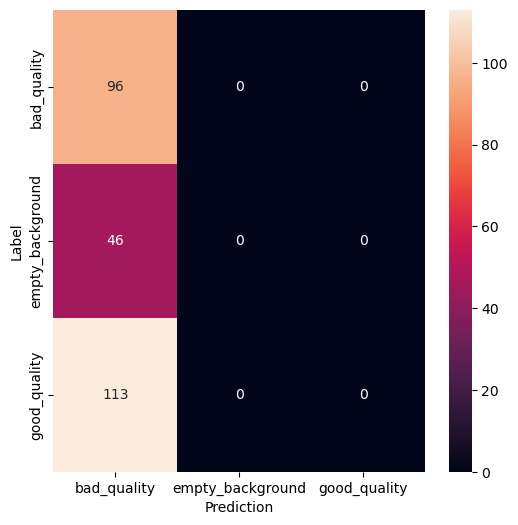

In [81]:
my_plot = show_confusion_matrix(confusion_mtx, labels)

In [82]:
#my_plot.show()

## Code reserved for troubleshooting

In [83]:
# def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
#     model = tf.keras.applications.mobilenet.MobileNet(
#         input_shape=input_shape,
#         alpha=alpha,
#         depth_multiplier=1,
#         dropout=0.001,
#         include_top=True,
#         weights=None, #'imagenet'
#         input_tensor=None,
#         pooling=None,
#         classes=classes,
#         classifier_activation='softmax',
#         #**kwargs
#     )

#     #model._name = model.name + "_keras" # model.name cannot be overritten

#     return model
#     #model = mobilenet_v1_keras((IMG_WIDTH, IMG_HEIGHT, 3), classes=classes, alpha=alpha)

In [84]:
# #os.environ["WANDB_MODE"] = "online"
# def train_model(model):

#         # solve issue from: https://github.com/wandb/wandb/issues/3536
#         # if len(wandb.patched["tensorboard"]) > 0:
#         #         wandb.tensorboard.unpatch()
                
#         # Configure Tensorboard root log directory to read the debugging information
#         #wandb.tensorboard.patch(root_logdir=root_logdir)
#         # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
#         # wandb.init(
#         #         # Set the project where this run will be logged
#         #         project=PROJECT, 
#         #         # Track hyperparameters and run metadata
#         #         #config={
#         #         #"learning_rate": LR,
#         #         #"epochs": EPOCHS,
#         #         #},
#         #         sync_tensorboard=True
#         #         )



#         # config = wandb.config
#         # # Specify the configuration variables
#         # config.batch_size = BATCH_SIZE
#         # config.dropout =DROPOUT
#         # config.learn_rate = LR
#         # #config.decay = 1e-6
#         # #config.momentum = 0.9
#         # config.epochs = EPOCHS
#         # config.classes = classes
        

#         # enable Tensorflow Debugging
#         #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
#         #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

#         #model = mobilenet
#         model.compile(optimizer='adam',
#                         loss='sparse_categorical_crossentropy',
#                         metrics=['accuracy'])

#         logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#         #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
#         tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir) #, histogram_freq=1)
#         #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

#         early_stopping = EarlyStopping(monitor="val_accuracy", patience= early_stopping_patience)

#         #checkpoint = ModelCheckpoint("my_tiny_model", save_weights_only=True)

#         callbacks =[
#                 #tensorboard_callback,
#                 #wandb_callback,
#                 #WandbMetricsLogger(),
#                 #checkpoint,
#                 #early_stopping
#         ]

#         history = model.fit(train_ds,
#                 epochs=EPOCHS, 
#                 validation_data=val_ds, 
#                 callbacks=callbacks
#         )

#         # wandb.log({
#         #         "loss": history.history["loss"],
#         #         "accuracy": history.history["accuracy"],
#         #         "val_loss": history.history["val_loss"],
#         #         "val_accuracy": history.history["val_accuracy"],                                
#         # })
        
#         #wandb.finish()
#         return history, model
